In [1]:
import ee
import datetime as dt

In [59]:
import pandas as pd

In [2]:
import folium
import json

In [3]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g44w2L3ek6v6OiP2X30AcNBLNfZRL_keEEdWQr_fqchASMjWyrJYSw

Successfully saved authorization token.


Load MODIS Terra NDSI image collection

In [4]:
coll = ee.ImageCollection("MODIS/006/MOD10A1")

In [5]:
count = coll.size().getInfo()
print(count)

7590


In [6]:
coll = coll.filterDate('2020-02-01', '2020-11-30')

In [7]:
count = coll.size().getInfo()
print(count)

301


---

Load polygon for Tanana Valley West (TVW) Predictive Service Area (PSA) 

In [8]:
with open("../GIS/Tanana_Valley_West_WGS84.geojson") as src:
    aoi_json = json.load(src)

In [10]:
coords = aoi_json['features'][0]['geometry']['coordinates']
aoi_PSA = ee.Geometry.Polygon(coords)

---

Filter collection to select AOI. Run some tests. 

In [11]:
coll_PSA = coll.filterBounds(aoi_PSA)

In [12]:
testimg_PSA = coll_PSA.first().clip(aoi_PSA)

In [13]:
testimg_PSA.bandNames().getInfo()

['NDSI_Snow_Cover',
 'NDSI_Snow_Cover_Basic_QA',
 'NDSI_Snow_Cover_Algorithm_Flags_QA',
 'NDSI',
 'Snow_Albedo_Daily_Tile',
 'orbit_pnt',
 'granule_pnt',
 'NDSI_Snow_Cover_Class',
 'Snow_Albedo_Daily_Tile_Class']

In [14]:
testimg_PSA.projection().getInfo()

{'type': 'Projection',
 'crs': 'SR-ORG:6974',
 'transform': [463.312716528,
  0,
  -20015109.354,
  0,
  -463.312716527,
  10007554.677]}

In [81]:
testimg_PSA.date().getInfo()

{'type': 'Date', 'value': 1600128000000}

In [15]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

vis_params = {
    'bands': ['NDSI_Snow_Cover'],
    'min': 0.0,
    'max': 100.0,
    'palette': ['333f11', '206548', '008991', '4ca6d6', 'bbbbff'],
}
#  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[65, -150], zoom_start=5, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(testimg_PSA, vis_params, 'snow')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

---

Helper functions

In [16]:
def meanatscale(scale):
    return testimg_PSA.select('NDSI_Snow_Cover').reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': aoi_PSA,
        'scale': scale
        })

def getimgmean(img):
    return img.select('NDSI_Snow_Cover').reduceRegion(**{
        'reducer': ee.Reducer.mean(),
        'geometry': aoi_PSA,
        'scale': 500
        })

In [17]:
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=1000,
                                  bestEffort=True,
                                  maxPixels=1e13
                                  return_centroids=True):
    """Function generator"""
    def reduce_region_function(img):
        """Applies the ee.Image.reduceRegion() method.

        Args:
          img:
            An ee.Image to reduce to a statistic by region.

        Returns:
          An ee.Feature that contains properties representing the image region
          reduction results 
        """
        stat = img.reduceRegion(
            reducer=reducer,
            geometry=geometry,
            scale=scale,
            bestEffort=bestEffort,
            maxPixels=maxPixels)
        if return_centroids:
            geometry = geometry.centroid()
        return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
    return reduce_region_function

In [18]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
        reducer=ee.Reducer.toList().repeat(prop_names.size()),
        selectors=prop_names).get('list')
    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [21]:
type(aoi_PSA.centroid())

ee.geometry.Geometry

In [48]:
reduce_tomean = create_reduce_region_function(
    geometry=aoi_PSA, reducer=ee.Reducer.mean(), scale=500)

snowcover_stat_fc = ee.FeatureCollection(coll_PSA.select('NDSI_Snow_Cover').map(reduce_tomean))

Run code in GEE

In [49]:
snowcover_mean = snowcover_stat_fc.getInfo()

Inspect output

In [57]:
snowcover_mean["features"][1]["properties"]

{'NDSI_Snow_Cover': 47.755435668820994, 'millis': 1580601600000}

Stuff the output into a Pandas Dataframe and visualize

In [58]:
helperlist = [item["properties"] for item in snowcover_mean["features"]]

In [62]:
snow_TananaValleyWest_2020 = pd.DataFrame(helperlist)

In [63]:
def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

In [64]:
snow_TananaValleyWest_2020 = add_date_info(snow_TananaValleyWest_2020)

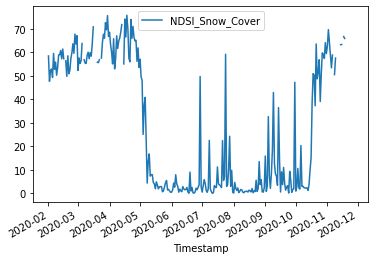

In [68]:
snow_TananaValleyWest_2020[["Timestamp", "NDSI_Snow_Cover"]].set_index("Timestamp").plot()

In [70]:
snow_TananaValleyWest_2020[["Timestamp", "NDSI_Snow_Cover"]].to_csv("TVW_2020_MODIS")

In [29]:
#out = meanatscale(testimg_PSA.projection().nominalScale())
for ii in range(1, 10):
    sc = ii * 125
    print(f"at scale {sc}m:")
    out = meanatscale(sc)
    print(out.getInfo())

at scale 125m:
{'NDSI_Snow_Cover': 58.52218127124157}
at scale 250m:
{'NDSI_Snow_Cover': 58.52944331625849}
at scale 375m:
{'NDSI_Snow_Cover': 58.52628264278751}
at scale 500m:
{'NDSI_Snow_Cover': 58.52205554058297}
at scale 625m:
{'NDSI_Snow_Cover': 58.50813944004971}
at scale 750m:
{'NDSI_Snow_Cover': 58.53863777993241}
at scale 875m:
{'NDSI_Snow_Cover': 58.639193823127506}
at scale 1000m:
{'NDSI_Snow_Cover': 58.58108675077013}
at scale 1125m:
{'NDSI_Snow_Cover': 58.61785463310546}
